In [4]:
import tensorflow as tf
x = tf.constant(2.0)
tf.math.exp(x)

<tf.Tensor: shape=(), dtype=float32, numpy=7.389056205749512>

In [5]:
import tensorflow as tf
print(tf.__version__)


2.18.0


Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.





Compiling model...
'compile' took 0.030609 s

Training model...

Step      Train loss              Test loss               Test metric
0         [3.36e+01, 2.04e+00]    [5.93e+01, 2.04e+00]    []  
1000      [3.90e-02, 4.72e-02]    [3.24e-02, 4.72e-02]    []  
2000      [5.14e-03, 2.84e-04]    [3.74e-03, 2.84e-04]    []  
3000      [2.35e-03, 2.51e-05]    [2.04e-03, 2.51e-05]    []  
4000      [1.31e-03, 6.15e-06]    [1.25e-03, 6.15e-06]    []  
5000      [7.61e-04, 2.19e-06]    [7.71e-04, 2.19e-06]    []  
6000      [4.41e-04, 1.06e-06]    [4.56e-04, 1.06e-06]    []  
7000      [2.60e-04, 6.32e-07]    [2.62e-04, 6.32e-07]    []  
8000      [1.66e-04, 4.42e-07]    [1.61e-04, 4.42e-07]    []  
9000      [2.42e-04, 5.58e-07]    [4.19e-04, 5.58e-07]    []  
10000     [8.91e-05, 2.78e-07]    [8.76e-05, 2.78e-07]    []  

Best model at step 10000:
  train loss: 8.94e-05
  test loss: 8.79e-05
  test metric: []

'train' took 183.026291 s



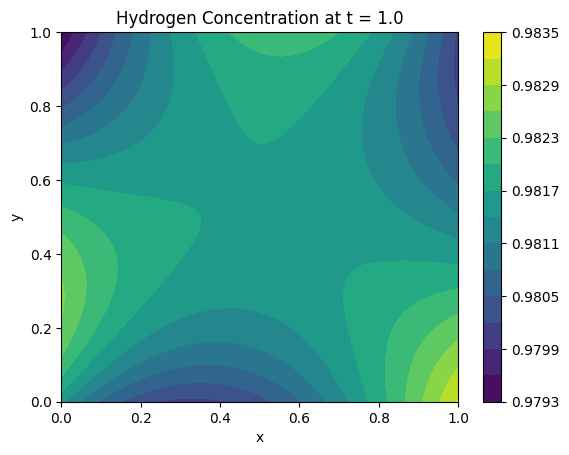

In [ ]:
import os
os.environ['DDE_BACKEND'] = 'tensorflow'
import numpy as np
import deepxde as dde
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.tri as tri

# Constants
D = 3.8e-20           # Diffusion coefficient
k = 1.380649e-23   # Boltzmann's constant (in J/K)
T = 300.0          # Absolute temperature (in K)

# Domain dimensions
L_x = 1.0
L_y = 1.0

# PDE residual
def pde(x, c):
    dc_dt = dde.grad.jacobian(c, x, i=0, j=2)

    # Compute gradients
    dc_dx = dde.grad.jacobian(c, x, i=0, j=0)
    dc_dy = dde.grad.jacobian(c, x, i=0, j=1)
    d2c_dx2 = dde.grad.hessian(c, x, component=0, i=0, j=0)
    d2c_dy2 = dde.grad.hessian(c, x, component=0, i=1, j=1)
    
    def E_t(x):
        # Example: A Gaussian trap in the center of the plate
        x_center, y_center = 0.5, 0.5
        sigma = 0.1
        return tf.math.exp(-((x[:, 0:1] - x_center) ** 2 + (x[:, 1:2] - y_center) ** 2) / (2 * sigma ** 2))
    # Gradient of trapping energy
    E_t_val = E_t(x)
    dE_dx = dde.grad.jacobian(E_t_val, x,i=0,j=0)
    dE_dy = dde.grad.jacobian(E_t_val, x,i=0,j=1)

    # Divergence term
    div_term = (dE_dx * dc_dx + dE_dy * dc_dy) * (D / (k * T)) + \
               c * (D / (k * T)) * (d2c_dx2 + d2c_dy2)

    # PDE residual
    residual = dc_dt - D * (d2c_dx2 + d2c_dy2) - div_term
    return residual

# Initial condition: c(x, y, t=0) = c0(x, y)
def initial_condition(x):
    # Example: Uniform initial concentration
    return np.ones((len(x), 1))

# Boundary condition: Zero-flux (Neumann)
def boundary(x, on_boundary):
    return on_boundary

def neumann_bc(x, on_boundary, component):
    return dde.bc.NeumannBC(geomtime, lambda x: 0, boundary, component=component)

# Geometry and time domain
geom = dde.geometry.Rectangle([0, 0], [L_x, L_y])
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Define the PINN model
data = dde.data.TimePDE(
    geomtime,
    pde,
    [dde.IC(geomtime, initial_condition, lambda _, on_initial: on_initial)],
    num_domain=2000,
    num_boundary=1000,
    num_initial=1000,
    num_test=1000,
)

# Neural network
net = dde.maps.FNN([3] + [50] * 3 + [1], "tanh", "Glorot normal")

# Model
model = dde.Model(data, net)

# Compile and train the model
model.compile("adam", lr=0.0001)
losshistory, train_state = model.train(iterations=10000)


# Generate prediction points
nx, ny = (50, 50)
x = np.linspace(0, L_x, nx)
y = np.linspace(0, L_y, ny)
X, Y = np.meshgrid(x, y)
X_flat = X.flatten()
Y_flat = Y.flatten()
T = np.full_like(X_flat, 1.0)  # Time at which we want the solution

input_points = np.vstack((X_flat, Y_flat, T)).T
c_pred = model.predict(input_points)

# Plotting the concentration at t = 1.0
fig, ax = plt.subplots()
triang = tri.Triangulation(X_flat, Y_flat)
ax.tricontourf(triang, c_pred.flatten(), levels=14)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Hydrogen Concentration at t = 1.0')
plt.colorbar(ax.tricontourf(triang, c_pred.flatten(), levels=14), ax=ax)
plt.show()


MovieWriter imagemagick unavailable; using Pillow instead.


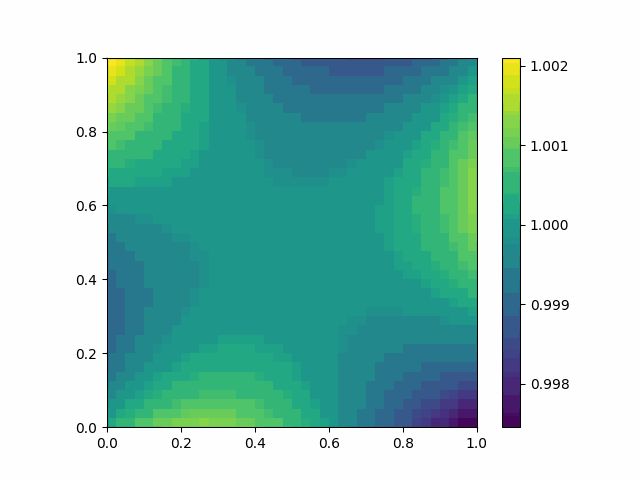

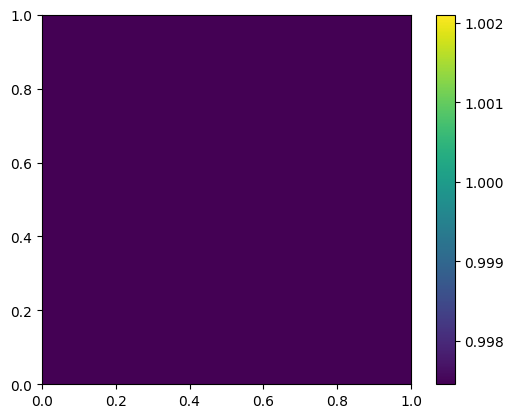

In [15]:
#Plot
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import Image
from IPython.display import display
length=1
resolution = 40
radius = 0.2
time=1
t= np.linspace(0, time, resolution)
x = np.linspace(0, length, resolution)
y = np.linspace(0, length, resolution)
data = np.zeros((resolution,resolution, resolution))
# Generate frames for each time step
for h in range(resolution):
    for i in range(resolution):
        for j in range(resolution):
            # Pass individual x, y, t values to model.predict()
             prediction= model.predict([[x[i], y[j], t[h]]])[0][0]
             data[i, j , h]=prediction
             
    # Apply mask for the central hole
    
    

    
# Initialize the plot
fig, ax = plt.subplots()
contour = ax.imshow(data[:,:,0], extent=[0, length, 0, length], origin="lower", cmap="viridis")
fig.colorbar(contour)

# Update function for each frame
def update(frame):
    contour.set_data(data[:,:,frame])
    return [contour]

# Create the animation
anim = FuncAnimation(fig, update, frames=resolution, interval=500, blit=True)
anim.save("animation.gif", writer="imagemagick")
# Display the animation
display(Image(filename="animation.gif"))

Compiling model...
'compile' took 0.000087 s

Training model...

0         [4.99e+18, 4.00e+02]    [4.98e+18, 4.00e+02]    []  
1000      [5.25e+12, 4.00e+02]    [4.43e+12, 4.00e+02]    []  
2000      [5.11e+12, 4.00e+02]    [4.32e+12, 4.00e+02]    []  
3000      [4.88e+12, 4.00e+02]    [4.12e+12, 4.00e+02]    []  
4000      [4.54e+12, 4.00e+02]    [3.82e+12, 4.00e+02]    []  
5000      [4.07e+12, 4.00e+02]    [3.41e+12, 4.00e+02]    []  
6000      [3.47e+12, 4.00e+02]    [2.89e+12, 4.00e+02]    []  
7000      [2.74e+12, 4.00e+02]    [2.25e+12, 4.00e+02]    []  
8000      [1.91e+12, 4.00e+02]    [1.53e+12, 4.00e+02]    []  
9000      [1.10e+12, 4.00e+02]    [8.31e+11, 4.00e+02]    []  
10000     [5.22e+11, 4.00e+02]    [3.47e+11, 4.00e+02]    []  
11000     [2.58e+11, 4.00e+02]    [1.41e+11, 4.00e+02]    []  
12000     [1.89e+11, 4.00e+02]    [9.06e+10, 4.00e+02]    []  
13000     [1.70e+11, 4.00e+02]    [7.69e+10, 4.00e+02]    []  
14000     [1.53e+11, 4.00e+02]    [6.50e+10, 4.00e+02

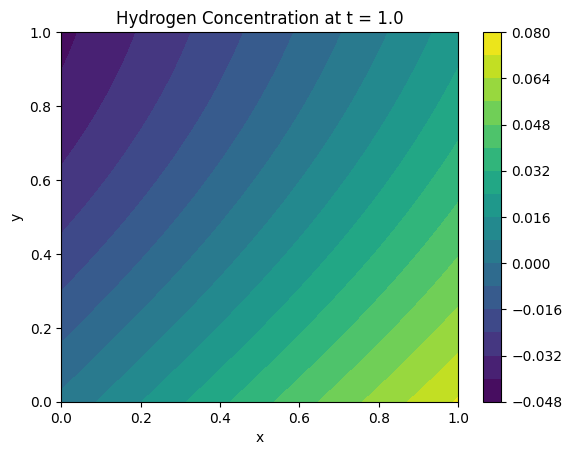

: 

In [ ]:
import os
os.environ['DDE_BACKEND'] = 'pytorch'
import numpy as np
import deepxde as dde
import torch
import matplotlib.pyplot as plt
import matplotlib.tri as tri



# Constants
D = 3.8e-11         # Diffusion coefficient
k = 1.380649e-23   # Boltzmann's constant (in J/K)
T = 300.0          # Absolute temperature (in K)
t_last = 0.1  # s
# Domain dimensions
L = 6e-2  # m
R = 4e-3  # m
# Initial condition for C_L
def initial_condition(x):
    return 20.0  # Initial value of C_L
ic = dde.icbc.IC(geomtime, initial_condition, lambda x, on_initial: on_initial, component=0)
# Trapping energy function E_t(x, y)
def E_t(x):
    x_center, y_center = 0, 0
    sigma = 0.1
    return torch.exp(-((x[:, 0:1] - x_center) ** 2 + (x[:, 1:2] - y_center) ** 2) / (2 * sigma ** 2))

# PDE residual function
def pde(x, c):
    dc_dt = dde.grad.jacobian(c, x, i=0, j=2)

    # Compute gradients
    dc_dx = dde.grad.jacobian(c, x, i=0, j=0)
    dc_dy = dde.grad.jacobian(c, x, i=0, j=1)
    d2c_dx2 = dde.grad.hessian(c, x, component=0, i=0, j=0)
    d2c_dy2 = dde.grad.hessian(c, x, component=0, i=1, j=1)

    # Gradient of trapping energy
    E_t_val = E_t(x)
    dE_dx = torch.autograd.grad(E_t_val, x, grad_outputs=torch.ones_like(E_t_val), retain_graph=True)[0][:, 0:1]
    dE_dy = torch.autograd.grad(E_t_val, x, grad_outputs=torch.ones_like(E_t_val), retain_graph=True)[0][:, 1:2]

    # Divergence term
    div_term = (dc_dx +  dc_dy) * (D / (k * T)) + \
               c * (D / (k * T)) * (d2c_dx2 + d2c_dy2)

    # PDE residual
    residual = dc_dt - D * (d2c_dx2 + d2c_dy2) - div_term
    return residual


# Boundary condition: Zero-flux (Neumann)
def boundary(x, on_boundary):
    return on_boundary

# Define Geometry and Time Domain
square = dde.geometry.Rectangle([0, 0], [L, L])
circle = dde.geometry.Disk([0, 0], R)
geom = dde.geometry.csg.CSGDifference(square, circle)
timedomain = dde.geometry.TimeDomain(0, t_last)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)
# Define the PINN model
data = dde.data.TimePDE(
    geomtime,
    pde,
    [ic],
    num_domain=2000,
    num_boundary=1000,
    num_initial=1000,
    num_test=1000,
)

# Neural network
net = dde.maps.FNN([3] + [50] * 3 + [1], "tanh", "Glorot normal")

# Model
model = dde.Model(data, net)

# Compile and train the model
model.compile("adam", lr=1e-5)
losshistory, train_state = model.train(epochs=50000)

# Generate prediction points
nx, ny = (50, 50)
x = np.linspace(0, L_x, nx)
y = np.linspace(0, L_y, ny)
X, Y = np.meshgrid(x, y)
X_flat = X.flatten()
Y_flat = Y.flatten()
T = np.full_like(X_flat, 1.0)  # Time at which we want the solution

input_points = np.vstack((X_flat, Y_flat, T)).T
c_pred = model.predict(input_points)

# If using PyTorch, detach before converting to NumPy
c_pred = c_pred.detach().numpy() if isinstance(c_pred, torch.Tensor) else c_pred

# Plotting the concentration at t = 1.0
fig, ax = plt.subplots()
triang = tri.Triangulation(X_flat, Y_flat)
contour = ax.tricontourf(triang, c_pred.flatten(), levels=14)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Hydrogen Concentration at t = 1.0')
plt.colorbar(contour, ax=ax)
plt.show()


In [ ]:
import numpy as np
import torch

# Generate a grid of test points over the domain
nx, ny = 50, 50
x = np.linspace(0, L_x, nx)
y = np.linspace(0, L_y, ny)
X, Y = np.meshgrid(x, y)
X_flat = X.flatten()
Y_flat = Y.flatten()
T = np.full_like(X_flat, 1.0)  # Example: testing at t = 1.0

test_points = np.vstack((X_flat, Y_flat, T)).T
c_pred = model.predict(test_points)
c_pred = torch.tensor(c_pred, requires_grad=True)

# Calculate the residual at each test point
residuals = []
for i in range(test_points.shape[0]):
    x = torch.tensor(test_points[i:i+1], requires_grad=True)
    c = model.predict(x)
    residual = pde(x, c)
    residuals.append(residual.detach().numpy())

# Convert residuals to a numpy array for easier handling
residuals = np.array(residuals).flatten()

# Print or plot the residuals to verify
print("Average PDE residual:", np.mean(np.abs(residuals)))


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.